In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from star import AlphaSTARCalculator, ProtonSTARCalculator, ProtonMaterials
import scipy.interpolate

material = ProtonMaterials.SILICON
calculator = ProtonSTARCalculator(material)
alpha_calculator = AlphaSTARCalculator(material)

density_of_silicon_specific = 2.33 #g/cm3

## Generating energy deposition profiles

In [16]:
def calc_energy_from_rigidity_in_MeV(rigidity_in_GV,Z=1,A=1):
    T0 = A * 0.938
    energy_in_GeV = -T0 + np.sqrt(T0**2 + ((rigidity_in_GV * Z / A)**2))
    return energy_in_GeV * 1000.0

In [17]:
def rndm_power_law(a, b, lamb, size=1):
    g=lamb + 1
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

In [18]:
def uniform_to_length(uniform_array,thickness):
    return np.sqrt(thickness**2 / (1.0 - uniform_array))

def length_generator(n_particles,thickness):
    uniform_array = np.random.uniform(0,1,n_particles)
    array_of_lengths = uniform_to_length(uniform_array,thickness)
    return array_of_lengths

In [102]:
from CosRayModifiedISO import CosRayModifiedISO
import datetime as dt

datetimeToUse = dt.datetime(
  year = 2001, #year = 2001,
  month = 10,
  day = 27,
  hour = 0,
  minute = 10,
  second = 35
  )

n_cos_ray_protons = 500000
n_cos_ray_alphas = 500000
  
def get_monte_carlo_cos_ray_values(datetimeToUse, n_cos_rays, atomicNumber=1):
    cos_ray_specs_DF = CosRayModifiedISO.getSpectrumUsingTimestamp(datetimeToUse,atomicNumber=atomicNumber)

    integral_flux_rigidities = (cos_ray_specs_DF["Rigidity (GV/n)"].iloc[:-1] + cos_ray_specs_DF["Rigidity (GV/n)"].iloc[1:]).iloc[:-1]/2
    integral_flux = np.cumsum(cos_ray_specs_DF["d_Flux / d_R (cm-2 s-1 sr-1 (GV/n)-1)"].iloc[:-1] * np.diff(cos_ray_specs_DF["Rigidity (GV/n)"]))
  #plt.xscale("log")
  #plt.yscale("log")

    integral_flux_rigidities = np.concatenate([[0.0],integral_flux_rigidities])
    integral_flux = np.concatenate([[0.0],integral_flux])

    total_fluence = max(integral_flux)

    inverse_integral_flux_interp = scipy.interpolate.interp1d(integral_flux/total_fluence, integral_flux_rigidities,
                                                          kind="linear",
                                                          bounds_error=False,fill_value=np.nan)

    return inverse_integral_flux_interp(np.random.random(n_cos_rays))



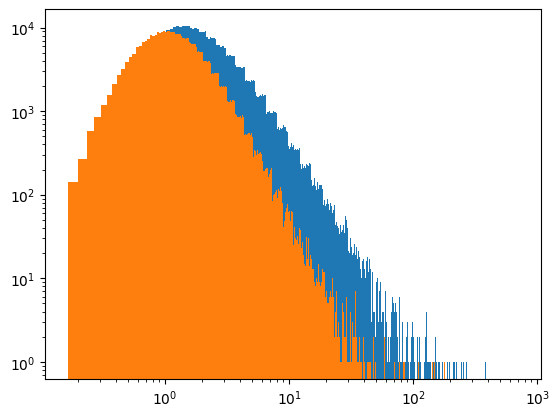

In [103]:
cos_ray_rigidity_vals = get_monte_carlo_cos_ray_values(datetimeToUse, n_cos_ray_protons)
plt.hist(cos_ray_rigidity_vals,bins=10000)


alpha_cos_ray_rigidity_vals = get_monte_carlo_cos_ray_values(datetimeToUse, n_cos_ray_alphas, atomicNumber=2)
plt.hist(alpha_cos_ray_rigidity_vals,bins=10000)

plt.xscale("log")
plt.yscale("log")

In [99]:
#n_particles_specific = 1_000_000
det_thickness_cm_specific = 30 / 10_000 #15 / 10_000
#power_law_index = 5

def calculate_MC_DF(array_of_rigidities_in_GV, det_thickness_cm, density_of_silicon, particle="proton"): #, use_uniform_STP=False):
    output_DF = pd.DataFrame()

    # if use_uniform_STP is True:
    #     output_DF["stopping_power_vals"] = np.random.random(size=n_particles)
    # else:
    #     output_DF["energy_vals"] = calc_energy_from_rigidity_in_MeV(rndm_power_law(1, 1000, lamb=-power_law_index, size=n_particles))
    #     output_DF["stopping_power_vals"] = calculator.calculate_total_stopping_powers(output_DF["energy_vals"]) * density_of_silicon
    
    if particle == "proton":
        output_DF["energy_vals"] = calc_energy_from_rigidity_in_MeV(array_of_rigidities_in_GV)
        output_DF["stopping_power_vals"] = calculator.calculate_total_stopping_powers(output_DF["energy_vals"]) * density_of_silicon
    elif particle == "alpha":
        output_DF["energy_vals"] = calc_energy_from_rigidity_in_MeV(array_of_rigidities_in_GV,Z=2,A=4)
        output_DF["stopping_power_vals"] = alpha_calculator.calculate_total_stopping_powers(output_DF["energy_vals"]) * density_of_silicon

    output_DF["length_vals"] = length_generator(len(array_of_rigidities_in_GV),det_thickness_cm)

    output_DF["tot_deposit_vals_MeV"] = output_DF["stopping_power_vals"] * output_DF["length_vals"]
    output_DF["tot_deposit_vals_keV"] = output_DF["tot_deposit_vals_MeV"] * 1000

    return output_DF

output_DF = calculate_MC_DF(cos_ray_rigidity_vals, det_thickness_cm_specific, density_of_silicon_specific)

In [67]:
output_DF

,energy_vals,stopping_power_vals,length_vals,tot_deposit_vals_MeV,tot_deposit_vals_keV
0,195.287128,8.581454,0.003842,0.032968,32.967993
1,574.033576,4.923207,0.009781,0.048155,48.154561
2,638.567718,4.740505,0.003608,0.017104,17.104217
3,1990.185761,3.881484,0.004742,0.018408,18.407545
4,2836.499056,3.879087,0.006305,0.024458,24.457732
...,...,...,...,...,...
499995,26593.463233,4.617150,0.003934,0.018166,18.165715
499996,13681.968289,4.386277,0.005443,0.023875,23.874577
499997,767.729193,4.476544,0.003385,0.015153,15.153038
499998,765.376952,4.480441,0.004192,0.018781,18.781259


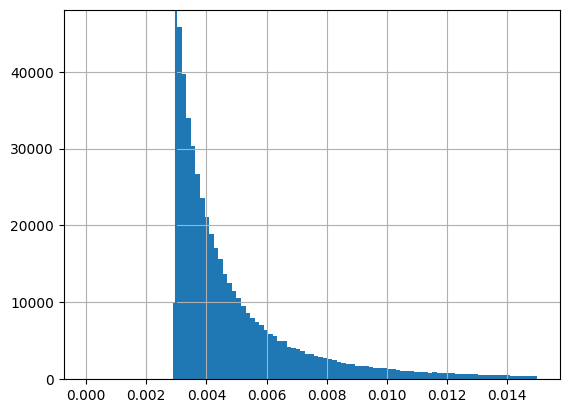

In [77]:
output_DF["length_vals"].hist(bins=np.linspace(0,det_thickness_cm_specific*5,100))
plt.axvline(det_thickness_cm_specific)

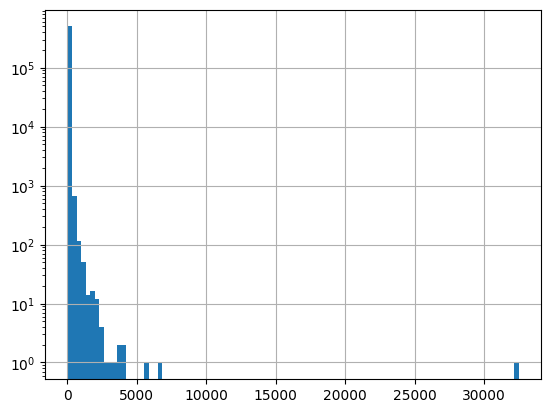

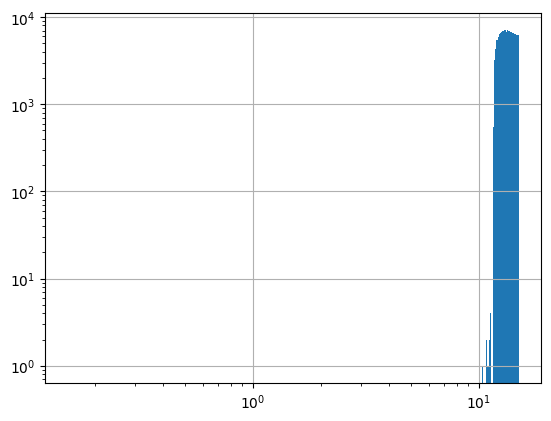

In [68]:
output_DF["tot_deposit_vals_keV"].hist(bins=100)
plt.yscale("log")
plt.figure()
output_DF["tot_deposit_vals_keV"].hist(bins=np.linspace(0,15,100))
plt.xscale("log")
plt.yscale("log")

In [93]:
dir(calculator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calculate_csda_ranges',
 'calculate_detour_factors',
 'calculate_electronic_stopping_powers',
 'calculate_nuclear_stopping_powers',
 'calculate_projected_range',
 'calculate_table',
 'calculate_total_stopping_powers',
 'default_energy',
 'splines']

In [95]:
calculator.calculate_total_stopping_powers(2000) * density_of_silicon_specific * det_thickness_cm_specific * 1000.0

np.float64(11.642572358430002)

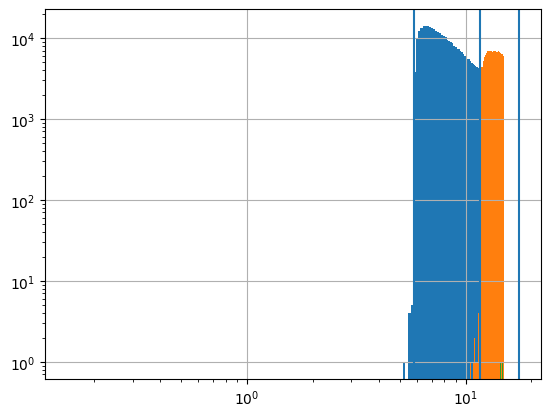

In [82]:
for det_thick in [15e-4, 30e-4, 45e-4]:
    calculate_MC_DF(cos_ray_rigidity_vals, det_thick, density_of_silicon_specific)["tot_deposit_vals_keV"].hist(bins=np.linspace(0,15,100))
    plt.axvline(calculator.calculate_total_stopping_powers(2000) * density_of_silicon_specific * det_thick* 1000.0)

plt.xscale("log")
plt.yscale("log")

## reconstructing spectra

In [25]:
reverse_stp_function = scipy.interpolate.interp1d(calculator.calculate_total_stopping_powers(np.linspace(1,2_000,10_000)) * density_of_silicon_specific,
                                                  np.linspace(1,2_000,10_000),bounds_error=False,fill_value=(0.0,1.0))

In [26]:
def reverse_dist_to_stp(distribution_of_energy_deps,det_thickness_cm_specific,
                        edep_vals_to_use=None,edep_fluxes_to_use=None,
                        bins_to_use=10_000):

    if edep_fluxes_to_use is None:
        backwards_vals, backwards_edges = np.histogram(distribution_of_energy_deps,
                                                    bins=bins_to_use,density=True)

        backwards_edges_mids = (backwards_edges[:-1] + backwards_edges[1:]) / 2
    else:
        backwards_edges_mids = edep_vals_to_use
        backwards_vals = edep_fluxes_to_use

    differential = np.diff(0.5 * (backwards_edges_mids**3) * det_thickness_cm_specific * backwards_vals) / np.diff(backwards_edges_mids)

    backwards_edges_mids_super = (backwards_edges_mids[:-1] + backwards_edges_mids[1:])/2

    output_vals = differential / (backwards_edges_mids_super**2)

    return backwards_edges_mids_super, output_vals

In [27]:
def reverse_dist_to_Eprim(distribution_of_energy_deps,det_thickness_cm,
                          edep_vals_to_use=None,edep_fluxes_to_use=None,
                          bins_to_use=10_000):

    specific_bkg_edges, specific_output_vals = reverse_dist_to_stp(distribution_of_energy_deps, det_thickness_cm,
                                                                   edep_vals_to_use=edep_vals_to_use,edep_fluxes_to_use=edep_fluxes_to_use,
                                                                   bins_to_use=bins_to_use)

    stp_power_vals = specific_bkg_edges/det_thickness_cm

    prim_energy_values = reverse_stp_function(stp_power_vals)
    prim_energy_values_mid = (prim_energy_values[:-1] + prim_energy_values[1:]) / 2

    delta_stp_vals = np.diff(stp_power_vals)
    delta_prim_energy_vals = np.diff(prim_energy_values)

    specific_output_vals_mid = (specific_output_vals[:-1] + specific_output_vals[1:]) / 2

    return prim_energy_values_mid, specific_output_vals_mid * np.abs(delta_stp_vals / delta_prim_energy_vals)

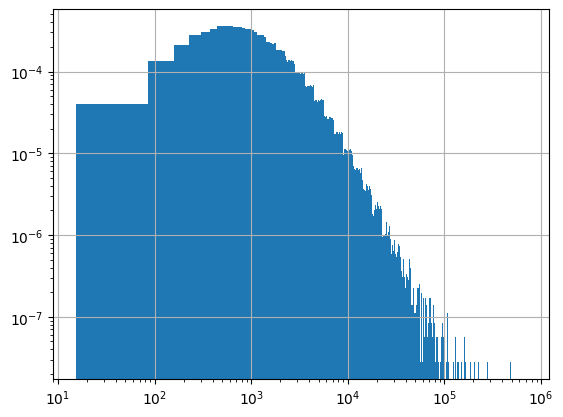

In [28]:
output_DF.energy_vals.hist(bins=10000,density=True)
plt.yscale("log")
plt.xscale("log")

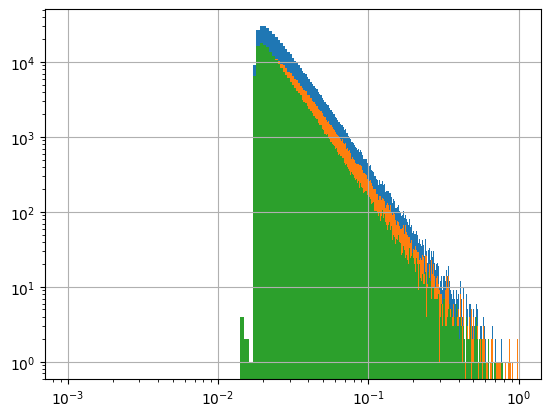

In [29]:
output_DF["tot_deposit_vals_MeV"].hist(bins=np.linspace(1e-3,1e0,1000))
output_DF.query("energy_vals < 2000")["tot_deposit_vals_MeV"].hist(bins=np.linspace(1e-3,1e0,1000))
output_DF.query("energy_vals >= 2000")["tot_deposit_vals_MeV"].hist(bins=np.linspace(1e-3,1e0,1000))
plt.yscale("log")
plt.xscale("log")
#plt.xlim([1e-3,2e-2])

In [30]:
reconstructed_E_vals, reconstructed_E_flux = reverse_dist_to_Eprim(output_DF["tot_deposit_vals_MeV"].dropna(),
                                                                   det_thickness_cm=det_thickness_cm_specific,
                                                                   bins_to_use=np.geomspace(1e-3,1e0,1000))

/tmp/ipykernel_456/1143382739.py:19: RuntimeWarning: divide by zero encountered in divide
  return prim_energy_values_mid, specific_output_vals_mid * np.abs(delta_stp_vals / delta_prim_energy_vals)
/tmp/ipykernel_456/1143382739.py:19: RuntimeWarning: invalid value encountered in multiply
  return prim_energy_values_mid, specific_output_vals_mid * np.abs(delta_stp_vals / delta_prim_energy_vals)


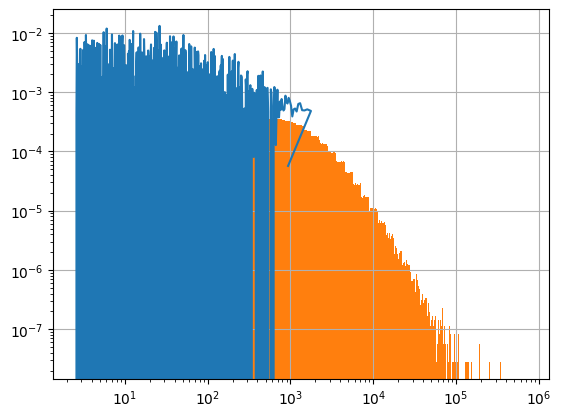

In [31]:
plt.plot(reconstructed_E_vals, reconstructed_E_flux)
plt.xscale("log")
plt.yscale("log")

output_DF.energy_vals.hist(bins=10000,density=True)
plt.yscale("log")
plt.xscale("log")